In [1]:
from keras.layers import Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
import keras.backend as K

import gym

import time

import numpy as np

Using TensorFlow backend.


In [2]:
class ReplayBuffer(object):
    def __init__(self, size, minibatch_size = None):
        """
        Args:
            size (integer): The size of the replay buffer.              
            minibatch_size (integer): The sample size.
        """
        self.buffer = []
        self.minibatch_size = minibatch_size
        self.rand_generator = np.random.RandomState()
        self.max_size = size
    #--------------------------------------------------------------------------------    

    def append(self, state, action, reward, next_state, done):
        """
        Args:
            state (Numpy array): The state.              
            action (integer): The action.
            reward (float): The reward.
            done (boolen): True if the next state is a terminal state and False otherwise.
                           Is transformed to integer so tha True = 1, False = 0
            next_state (Numpy array): The next state.           
        """
        if self.size() == self.max_size:
            del self.buffer[0]
        self.buffer.append([state, action, reward, next_state, int(done)])
    #--------------------------------------------------------------------------------    

    def sample(self):
        """
        Returns:
            A list of transition tuples including state, action, reward, terminal, and next_state
        """
        idxs = self.rand_generator.choice(np.arange(len(self.buffer)), size=self.minibatch_size)
        return [self.buffer[idx] for idx in idxs]
    #--------------------------------------------------------------------------------    

    def size(self):
        """
        Returns:
            Number of elements in the buffer
        """
        return len(self.buffer)
    #--------------------------------------------------------------------------------
    
    def min_full(self):
        '''
        Returns:
            Boolean indicating if the memory have the minimum number of elements or not
        '''
        return (self.size() >= self.minibatch_size)
    
    #--------------------------------------------------------------------------------
    def empties(self):
        self.buffer.clear()
    
    #--------------------------------------------------------------------------------
    def get_episode(self):
        return self.buffer
        

In [3]:
class Agent(object):
    def __init__(self, alpha, gamma, input_dims, layer1_size, layer2_size, n_actions, memory_size):
        self.alpha = alpha
        self.gamma = gamma
        self.G = 0
        self.input_dims = input_dims
        self.layer1_size = layer1_size
        self.layer2_size = layer2_size
        self.n_actions = n_actions
        self.memory = ReplayBuffer(memory_size)
        
        self.policy, self.predict = self.build_policy_network(alpha, input_dims, layer1_size, layer2_size, n_actions)
    
    #-----------------------------------------------------------------------------------------------
    def build_policy_network(self, alpha, input_dims, l1_size, l2_size, n_actions):
        input_layer = Input(shape=(input_dims, ))
        advantages = Input(shape=[1])
        dense1 = Dense(l1_size, activation='relu')(input_layer)
        dense2 = Dense(l2_size, activation='relu')(dense1)
        probs = Dense(n_actions, activation='softmax')(dense2)
        
        def custom_loss(y_true, y_pred):
            out = K.clip(y_pred, 1e-8, 1-1e-8)
            log_lik = y_true*K.log(out)
            
            return K.sum(-log_lik*advantages)
        
        policy = Model(inputs=[input_layer, advantages], outputs=[probs])
        policy.compile(optimizer=Adam(lr=alpha), loss=custom_loss)
        
        predict = Model(inputs=[input_layer], outputs=[probs])
        
        return policy, predict
    
    #-----------------------------------------------------------------------------------------------
    def choose_action(self, observation):
        state = observation[np.newaxis, :]
        probabilities = self.predict.predict(state)[0]
        action = np.random.choice(np.arange(self.n_actions), p=probabilities)
        
        one_hot_action = np.zeros(self.n_actions)
        one_hot_action[action] = 1.
        
        return action, one_hot_action
    
    #-----------------------------------------------------------------------------------------------
    def remember(self, state, action, reward, next_state, done):
        self.memory.append(state, action, reward, next_state, done)
        
    #-----------------------------------------------------------------------------------------------    
    def learn(self):
        experiences = self.memory.get_episode()
        states = np.array([exp[0] for exp in experiences])
        actions = np.array([exp[1] for exp in experiences])
        rewards = np.array([exp[2] for exp in experiences])
        
        G = np.zeros_like(rewards)
        
        for t in range(len(G)):
            G_sum = 0
            discount = 1
            for k in range(t, len(G)):
                G_sum += rewards[k]*discount
                discount *= self.gamma
            
            G[t] = G_sum
            
        mean = np.mean(G)
        std = np.std(G) if np.std(G) > 0 else 1
        self.G = (G - mean)/std
        
        cost = self.policy.train_on_batch([states, self.G], actions)
        
        self.memory.empties()
    
    #-----------------------------------------------------------------------------------------------   
    def train(self, env, num_episodes, verbose, finish_limit, finish_ratio=1):
        
        scores_history = []
        steps_history = []
        
        print("BEGIN\n")
        complete = 0

        for episode in range(num_episodes):
            done = False
            score = 0
            steps = 0
            observation = env.reset()

            while not done:
                print("\r                                                                                         ", end="")
                print("\rEpisode: "+str(episode+1)+"\tStep: "+str(steps)+"\tReward: "+str(score), end="")
                action, one_hot_action = self.choose_action(observation)
                new_observation, reward, done, _ = env.step(action)
                self.remember(observation, one_hot_action, reward, new_observation, done)
                observation = new_observation
                score += reward
                steps += 1

            self.learn()

            if(score >= finish_limit):
                complete += 1

            if((episode+1)%verbose == 0):
                print("\r                                                                                         ", end="")
                print("\rEpisodes: ", episode+1, "/", num_episodes
                      , "\n\tTotal reward: ", np.mean(scores_history[-verbose:])
                      , "\n\tNum. steps: ", np.mean(steps_history[-verbose:])
                      , "\n\tCompleted: ", complete, "\n--------------------------\n")
                
                if(complete >= finish_ratio*verbose):
                    scores_history.append(score)
                    steps_history.append(steps)
                    break

                complete = 0


            scores_history.append(score)
            steps_history.append(steps)

        print("\nFINISHED")
        
        return scores_history, steps_history

In [4]:
env = gym.make('LunarLander-v2')
alpha = 5e-4
gamma = 0.99
input_dims = env.observation_space.shape[0]
layer1_size = 128
layer2_size = 64
n_actions = env.action_space.n
memory_size = 1100
num_episodes = 5000
verbose = 250

agent = Agent(alpha, gamma, input_dims, layer1_size, layer2_size, n_actions, memory_size)

scores, steps = agent.train(env, num_episodes, verbose, finish_limit=200)

/home/gustavo/anaconda3/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


BEGIN

Episodes:  250 / 5000                                                                    
	Total reward:  -144.87934836531466 
	Num. steps:  104.30522088353413 
	Completed:  0 
--------------------------

Episodes:  500 / 5000                                                                    
	Total reward:  -109.01960870955224 
	Num. steps:  170.1 
	Completed:  0 
--------------------------

Episodes:  750 / 5000                                                                    
	Total reward:  -39.50626010775345 
	Num. steps:  274.268 
	Completed:  0 
--------------------------

Episodes:  1000 / 5000                                                                   
	Total reward:  21.248208884841745 
	Num. steps:  539.196 
	Completed:  0 
--------------------------

Episodes:  1250 / 5000                                                                   
	Total reward:  79.6018808508122 
	Num. steps:  773.856 
	Completed:  0 
--------------------------

Episodes:  1500 / 5

In [7]:
observation = env.reset()
done = False
cont = 0
while not done:
    env.render()
    time.sleep(0.02)
    if cont <= 0:
        action = env.action_space.sample()
    else:
        action, _ = agent.choose_action(observation)
    new_observation, reward, done, _ = env.step(action)
    observation = new_observation
    cont += 1
env.close()

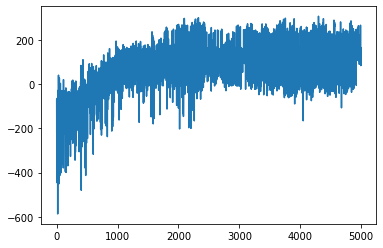

In [6]:
import matplotlib.pyplot as plt
t = np.arange(num_episodes)
plt.plot(t, scores)